In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import datetime
import re

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
#import pyLDAvis.gensim #LDA visualization library

import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain

from scipy.interpolate import *
from scipy.interpolate import make_interp_spline

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
data_folder = './MovieSummaries/'

summaries = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])

In [242]:
# mergin databases
summaries = summaries.merge(movie_meta, on="wiki_id", how = 'right')
summaries["languages"] = summaries.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
summaries["coutries"] = summaries.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
summaries["genres"] = summaries.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [243]:
# import dataset scraped from wikipedia

df_wikipedia = pd.read_json('with_plot.txt', lines=True)
df_wikipedia = df_wikipedia[['id', 'directors', 'plot']]
df_wikipedia.rename(columns={'id':'wiki_id', 'plot':'summary'}, inplace=True)
df_wikipedia = df_wikipedia[df_wikipedia['summary'].notna()] # only keep rows that have a plot summary

In [244]:
df_movies = summaries.copy()

In [245]:
len(summaries)

81741

In [246]:
summaries.loc[summaries['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(summaries['release_date'])
summaries['release_date'] = dates

In [247]:
# df is used for average sentiment analysis over movies
df = summaries.copy()

In [248]:
df = df.sort_values(by=['release_date'])

In [249]:
df = df.dropna(subset=['summary'])

In [250]:
df.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
25563,73372,The scene is all filmed from a stationary came...,/m/0jq3g,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67253,10109752,After finding out that her father is suffering...,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
81230,10104497,James J. Corbett and Peter Courtney both take ...,/m/02q1zd3,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67567,10330688,The film consists of a series of animations on...,/m/02q8pr6,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Short Film, Silent film, Animation, Comedy, I..."
73179,10483292,Two men stand working as blacksmiths. The one ...,/m/02qfh7r,Les Forgerons,1895-01-01,NaN,0.816667,[Silent film],[France],"[Short Film, Silent film, Indie, Black-and-whi..."


In [251]:
len(df)

42204

Here we have that df contains all the movies with their informations, ordered by release date with a existing summary. We will use this to derive all our other dataframes (per countries, per date). We have 42204 movies compared to 81741 before.

## Creation of a dataset with plot summmaries 

In [252]:
df_additional = summaries.copy()
df_additional = df_additional[df_additional['release_date'].notna()]  

In [253]:
# Method for a first cleanup of the data ; this will need more work in the future

def remove_html(line):
    CLEANR = re.compile('<!--.*--') 
    CLEANR2 = re.compile('<ref.*</ref')  
    CLEANR3 = re.compile('<Ref.*</ref')
    CLEANR4 = re.compile('<ref.*/>')
    x = re.sub(CLEANR, '', line)
    x = re.sub(CLEANR3, '', x)
    x = re.sub(CLEANR2, '', x)
    x = re.sub(CLEANR4, '', x)
    x = x.replace('\n', '') # remove newlines
    x = x.replace('([[', '') 
    x = x.replace(']])', '') 
    x = x.replace('[[', '') 
    x = x.replace(']]', '')
    x = x.replace('|', ' | ')
    x = x.replace('**', '"') 
    x = x.replace('*', "'") 
    if(len(line) < 50):
        x = ""      
    return x

# remove html references in plot summaries
df_wikipedia['summary'] = df_wikipedia['summary'].apply(lambda x : remove_html(x))



In [254]:
rows = df_wikipedia.sample(10)
for index, row in rows.iterrows():
    print(row['summary'])
    print("===================")

In the late 21st century, an Interstellar medium | interstellar war between humans (associated as the Bilateral Terran Alliance, or BTA) and Dracs (bipedal reptilian humanoids) is fought. Battles are periodically fought between fighter spacecraft, and no human hates the Dracs more than Willis E. Davidge. During one such battle, Davidge and Drac pilot Jareeba Sheegan engage in a dogfight, which results in them both crash-landing on Fyrine&nbsp;IV, a planet whose surface is largely a hostile volcanic wasteland. After initial hostilities where they viciously hunt one another, the two learn to cooperate to survive. Over the next three years they become friends, each saving the other's life several times.Davidge, haunted by dreams of spaceships landing on the planet, leaves in search of help. He finds evidence of humans, but learns that the planet has only periodically been visited by human miners known as Scavengers who use Dracs as slave labor. He returns to warn Jareeba, nicknamed 'Jerry

In [255]:
# Method that takes the wikipedia summary if the CMU database doesn't provide one

def pick_better_plot(x):
    if x.summary_x == '':
        if x['summary_y'] == '':
            return np.nan
        else:
            return x['summary_y']
    else:
        return x['summary_x']

# since we base our analysis on release dates, we remove films with no release date
df_additional = df_additional[df_additional['release_date'].notna()]  
    
summary_df = pd.merge(df_additional,df_wikipedia,on='wiki_id',how='left')
summary_df['summary_x'] = summary_df['summary_x'].fillna('')
summary_df['summary_y'] = summary_df['summary_y'].fillna('')


# create new column with the wikipedia summary if CMU doesn't provide one
summary_df['summary'] = summary_df.apply(lambda x : pick_better_plot(x),axis=1)

# keep only rows that have a summary
summary_df = summary_df[summary_df['summary'].notna()]
summary_df = summary_df.drop(columns=['summary_x', 'summary_y'])

In [256]:
analyzer = SentimentIntensityAnalyzer()

In [257]:
def get_country_movies(df, country):
    return df[df.coutries.apply(lambda x : country in x)]

In [258]:
def create_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year < end) & (df.release_date.dt.year > begin)]

In [259]:
def get_one_year(df, year):
    return df.loc[(df.release_date.dt.year == year)]

In [260]:
def plot_sentiment_country_span(span, attribute, year:bool):
    fig, axs = plt.subplots(figsize=(25, 5))
    if year:
        sentiments = span.groupby(span.release_date.dt.year)[attribute].mean()
    else:
        sentiments = span.groupby(span.release_date)[attribute].mean()
    sentiments.plot(kind='bar', rot=90, ax=axs)

In [261]:
def sentiment_df(df):
    
    df_copy = df.copy()
    
    # calculate the sentiment over the summaries
    df_copy['sentiment'] = df_copy['summary'].apply(lambda x: analyzer.polarity_scores(x))

    # isolate the most interesting values
    df_copy['positive'] = df_copy['sentiment'].apply(lambda x: x['pos'])
    df_copy['neutral'] = df_copy['sentiment'].apply(lambda x: x['neu'])
    df_copy['negative'] = df_copy['sentiment'].apply(lambda x: x['neg'])
    df_copy['compound'] = df_copy['sentiment'].apply(lambda x: x['compound'])
    
    return df_copy

In [262]:
# the texts are in english
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

Firstly we'll just look at movies made around the WW2, that is from 1930 to 1955.

In [263]:
begin = 1930
end = 1955

In [264]:
df_ww2 = create_history_span(summary_df, begin, end)
print("There is", len(df_ww2), "movies made worldwide bewteen", begin, "and", end)

There is 8237 movies made worldwide bewteen 1930 and 1955


We will first run a sentiment analysis over all **german** movie during this period **(1930 to 1955)**.

In [265]:
# get all the german movies
df_ww2_germany = get_country_movies(df_ww2, 'Germany')

# calculate sentiment and add it nicely to the df
df_ww2_germany = sentiment_df(df_ww2_germany)

In [266]:
print("There is", len(df_ww2_germany), "movies made in Germany bewteen", begin, "and", end)

There is 110 movies made in Germany bewteen 1930 and 1955


In [312]:
from collections import Counter
from empath import Empath


# get most common words across all summaries by summing up the summaries
def most_common_in_text(text):
    summary = nlp(text)
    tokens = [token.lemma_ for token in summary if token.is_stop != True and token.is_punct != True]
    tokens_lower = [x.lower() for x in tokens]
    return Counter(tokens_lower)

# from tutorial 10
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    

def most_common_sum(df, n):
    text = ' '.join(df["summary"])
    if(len(text) < 1000000):
        return most_common_in_text(text).most_common(n)
    else:
        chunks = [x for x in get_chunks(text,1000000)]
        master_list = []
        for chunk in chunks:
            counter = most_common_in_text(chunk).items()
            [master_list.append(x) for x in counter]
        d = {x: 0 for x, _ in master_list}
        for word, num in master_list:
            d[word] += num
        out = list(map(tuple, d.items()))
        sorted_list = sorted(out,key=lambda t: t[1],reverse=True)
        return sorted_list[0:n]
    
    
def topic_analysis(df, cats):
    text = ' '.join(df["summary"])
    lexicon = Empath()
    if(len(text) < 1000000):
        doc = nlp(text)
        return lexicon.analyze(doc.text,categories = cats, normalize=True)
    else:
        chunks = [x for x in get_chunks(text,1000000)]
        categories_sum =  dict(zip(cats, [0] * len(cats)))
        for chunk in chunks:
            doc = nlp(chunk)
            topics = lexicon.analyze(doc.text,categories = cats, normalize=True)
            for key, value in topics.items():
                categories_sum[key] += value
                
        for key, value in categories_sum.items():
            categories_sum[key] /= len(chunks)
        return categories_sum
    
def topic_analysis_by_year(df, begin, end, cats):
    categories_all =  dict(zip(cats, [ [] for _ in range(len(cats)) ]))
    for year in range(begin, end):
        df_year = get_one_year(df, year)
        categories_year = topic_analysis(df_year, cats)
        if categories_year is not None :
            for key, value in categories_year.items():
                old = categories_all[key]
                old.append(value)
                categories_all[key] = old
        else:
            for key, value in categories_all.items():
                old = categories_all[key]
                old.append(0)
                categories_all[key] = old
    return categories_all

def plot_topic_analysis_by_year(df, begin, end, cats, name, country):
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    values = topic_analysis_by_year(df, begin, end, cats)
    
    MAXIMUM_RANGE = 0.055
        
    x_axis = range(begin, end)
    colors = ["orange", "green", "blue", "black"]
    i = 0
    for j in range(2):
        for k in range(2):
            axs[j][k].plot(x_axis, values[cats[i]], label = cats[i], color=colors[i])
            axs[j][k].title.set_text(cats[i])
            axs[j][k].set_xlabel("Film release date")
            axs[j][k].set_ylabel("Frequency of the topic")
            i = i+1
            axs[j][k].set_ylim(0, MAXIMUM_RANGE)
    plt.tight_layout()
    fig.suptitle(country)
    plt.savefig(name)
    plt.show()

In [268]:
print(most_common_sum(df_ww2_germany, 40))

[('film', 73), ('german', 61), ('find', 53), ('war', 51), ('man', 49), ('love', 49), (' ', 46), ('von', 46), ('leave', 44), ('young', 41), ('take', 40), ('father', 40), ('fall', 37), ('return', 37), ('meet', 35), ('woman', 33), ('|', 32), ('order', 31), ('british', 31), ('girl', 31), ('tell', 31), ('manuela', 31), ('world', 30), ('escape', 29), ('die', 29), ('day', 29), ('play', 28), ('nazi', 28), ('work', 28), ('hitler', 27), ('end', 27), ('son', 27), ('plan', 27), ('follow', 26), ('try', 26), ('baron', 26), ('wife', 25), ('give', 25), ('old', 25), ('family', 25)]


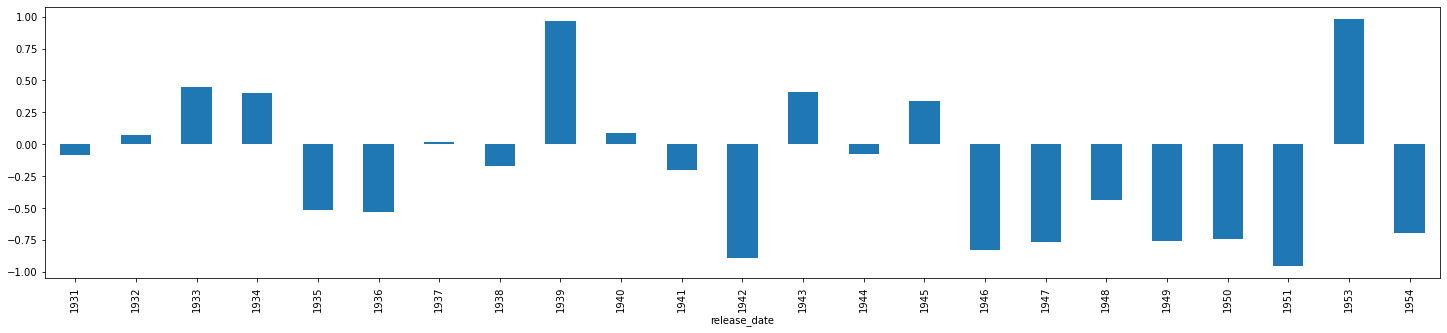

In [269]:
plot_sentiment_country_span(df_ww2_germany, 'compound', year=True)

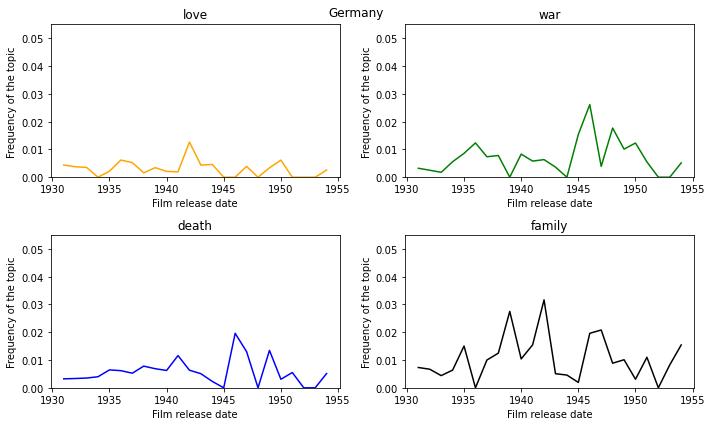

In [313]:
categories = ["love", "war", "death", "family"]
plot_topic_analysis_by_year(df_ww2_germany, begin+1, end, categories, "test", "Germany")


Seeing the compound value of all the movies at this period we can clearly see that the post war (1946-1951) overall sentiment is negative.

---

In [271]:
# This is for display the LDA of all the summaries of the dataframe.
display_ger, doc_term_matrix_ger, ldamodel_ger = LDA(df_ww2_germany, num_topics=5)
pyLDAvis.display(display_ger)

--- Here are all the topics found : ---
(0, '0.008*"german" + 0.005*"peter" + 0.005*"ship" + 0.005*"film" + 0.004*"polish" + 0.004*"han" + 0.004*"order" + 0.004*"end" + 0.003*"germany" + 0.003*"war"')
---
(1, '0.006*"gray" + 0.005*"film" + 0.005*"father" + 0.004*"war" + 0.004*"find" + 0.004*"king" + 0.004*"snowman" + 0.004*"old" + 0.004*"family" + 0.003*"german"')
---
(2, '0.006*"love" + 0.005*"german" + 0.005*"french" + 0.005*"michael" + 0.005*"film" + 0.005*"war" + 0.004*"two" + 0.004*"return" + 0.004*"russian" + 0.003*"plan"')
---
(3, '0.007*"baron" + 0.006*"one" + 0.005*"friedemann" + 0.005*"strauss" + 0.004*"young" + 0.004*"police" + 0.003*"two" + 0.003*"father" + 0.003*"baum" + 0.003*"waltz"')
---
(4, '0.010*"von" + 0.009*"manuela" + 0.008*"fräulein" + 0.007*"bernburg" + 0.006*"film" + 0.006*"girl" + 0.006*"hitler" + 0.005*"headmistress" + 0.004*"german" + 0.004*"nazi"')
---


We then run a sentiment analysis over all **french** movie during this period **(1930 to 1955)**.

In [272]:
# get all the french movies
df_ww2_french = get_country_movies(df_ww2, 'France')

# calculate sentiment and add it nicely to the df
df_ww2_french = sentiment_df(df_ww2_french)

In [273]:
print("There is", len(df_ww2_french), "movies made in France bewteen", begin, "and", end)

There is 193 movies made in France bewteen 1930 and 1955


In [274]:
print(most_common_sum(df_ww2_french, 40))

[('find', 138), (' ', 130), ('love', 125), ('man', 109), ('leave', 97), ('tell', 91), ('take', 91), ('young', 82), ('return', 82), ('woman', 81), ('film', 81), ('life', 69), ('go', 69), ('try', 68), ('|', 67), ('away', 63), ('wife', 62), ('father', 62), ('war', 60), ('paris', 58), ('end', 57), ('night', 56), ('come', 56), ('kill', 55), ('town', 55), ('day', 55), ('friend', 55), ('old', 53), ('french', 53), ('robert', 53), ('fall', 50), ('de', 50), ('police', 49), ('see', 47), ('run', 46), ('decide', 46), ('work', 45), ('jean', 44), ('time', 44), ('arrive', 44)]


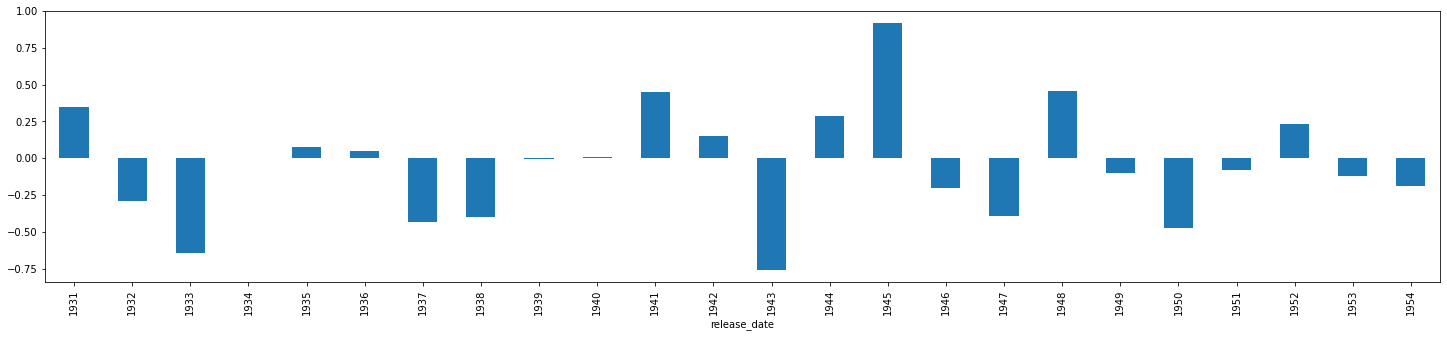

In [275]:
plot_sentiment_country_span(df_ww2_french, 'compound', year=True)

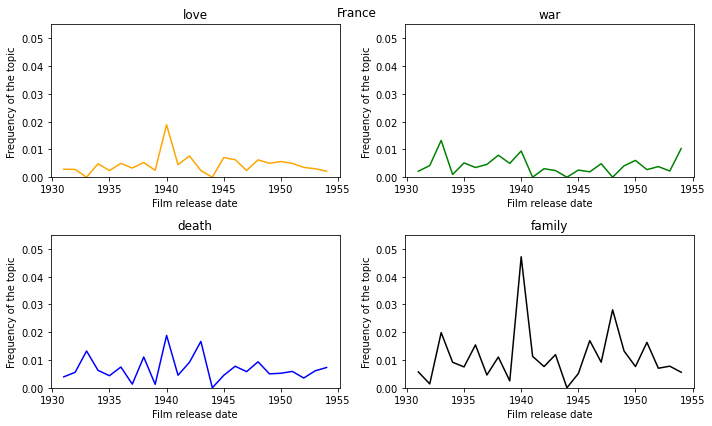

In [314]:
plot_topic_analysis_by_year(df_ww2_french, begin+1, end, categories, "test2", "France")

We can't see any form of pattern here ?... Except the 1945 year that is very positive (victory for France)

---

In [277]:
# This is for display the LDA of all the summaries of the dataframe.
display_fr, doc_term_matrix_fr, ldamodel_fr = LDA(df_ww2_french, num_topics=4)
pyLDAvis.display(display_fr)

--- Here are all the topics found : ---
(0, '0.006*"belle" + 0.005*"town" + 0.004*"take" + 0.004*"father" + 0.004*"find" + 0.004*"love" + 0.004*"beast" + 0.003*"go" + 0.003*"young" + 0.003*"man"')
---
(1, '0.005*"take" + 0.005*"get" + 0.004*"tell" + 0.004*"find" + 0.004*"film" + 0.004*"one" + 0.003*"him" + 0.003*"away" + 0.003*"night" + 0.003*"see"')
---
(2, '0.006*"love" + 0.004*"young" + 0.004*"martial" + 0.003*"her" + 0.003*"gaston" + 0.003*"get" + 0.003*"tell" + 0.003*"life" + 0.003*"cyrano" + 0.003*"gigi"')
---
(3, '0.005*"love" + 0.005*"find" + 0.005*"french" + 0.004*"woman" + 0.004*"de" + 0.004*"wife" + 0.004*"take" + 0.003*"war" + 0.003*"man" + 0.003*"film"')
---


We then run a sentiment analysis over all **italy** movie during this period **(1930 to 1955)**.

In [278]:
# get all the french movies
df_ww2_italy = get_country_movies(df_ww2, 'Italy')

# calculate sentiment and add it nicely to the df
df_ww2_italy = sentiment_df(df_ww2_italy)

In [279]:
print("There is", len(df_ww2_italy), "movies made in Italy bewteen", begin, "and", end)

There is 241 movies made in Italy bewteen 1930 and 1955


In [280]:
print(most_common_sum(df_ww2_italy, 40))

[('young', 127), ('find', 122), ('love', 116), (' ', 112), ('man', 107), ('leave', 93), ('take', 91), ('return', 83), ('film', 83), ('go', 81), ('woman', 80), ('son', 79), ('girl', 78), ('try', 78), ('life', 72), ('wife', 72), ('family', 71), ('kill', 68), ('|', 68), ('tell', 68), ('war', 67), ('end', 67), ('friend', 66), ('money', 66), ('antonio', 65), ('fall', 64), ('home', 63), ('time', 62), ('daughter', 62), ('father', 62), ('day', 61), ('work', 59), ('meet', 58), ('police', 57), ('decide', 57), ('house', 57), ('away', 57), ('town', 56), ('live', 56), ('marry', 55)]


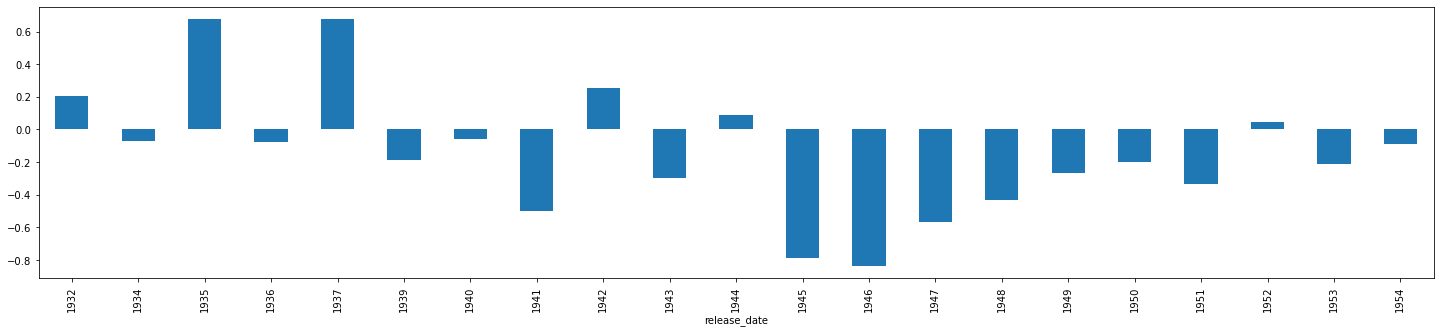

In [281]:
plot_sentiment_country_span(df_ww2_italy, 'compound', year=True)

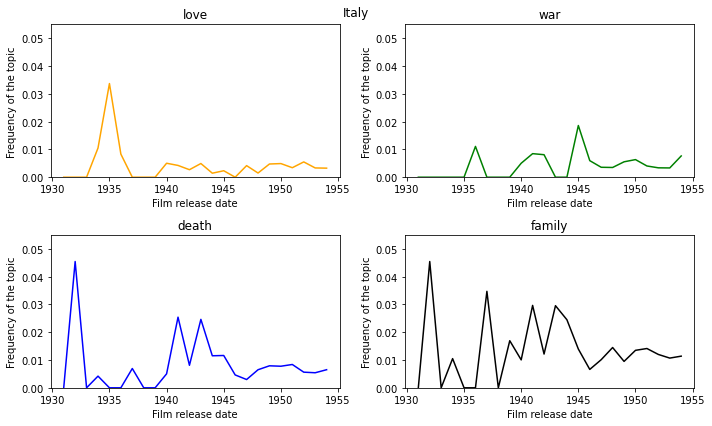

In [315]:
plot_topic_analysis_by_year(df_ww2_italy, begin+1, end, categories, "test3", "Italy")

Seeing the compound value of all the movies at this period we can clearly see that the post war (1945-1949) overall sentiment is negative.

---

In [283]:
# This is for display the LDA of all the summaries of the dataframe.
display_ita, doc_term_matrix_ita, ldamodel_ita = LDA(df_ww2_italy, num_topics=3)
pyLDAvis.display(display_ita)

--- Here are all the topics found : ---
(0, '0.004*"take" + 0.004*"young" + 0.003*"two" + 0.003*"get" + 0.003*"go" + 0.003*"woman" + 0.003*"boy" + 0.003*"film" + 0.003*"town" + 0.003*"pasquale"')
---
(1, '0.005*"young" + 0.005*"love" + 0.004*"find" + 0.004*"him" + 0.004*"life" + 0.004*"go" + 0.004*"girl" + 0.003*"one" + 0.003*"two" + 0.003*"film"')
---
(2, '0.006*"antonio" + 0.004*"love" + 0.004*"one" + 0.004*"two" + 0.003*"go" + 0.003*"son" + 0.003*"young" + 0.003*"man" + 0.003*"family" + 0.003*"day"')
---


We then run a sentiment analysis over all **united kingdom** movie during this period **(1930 to 1955)**.

In [284]:
# get all the UK movies
df_ww2_UK = get_country_movies(df_ww2, 'United Kingdom')

# calculate sentiment and add it nicely to the df
df_ww2_UK = sentiment_df(df_ww2_UK)

In [285]:
topic_analysis(df_ww2_UK, categories)

{'love': 0.0023447576387750912,
 'war': 0.0037315031261970287,
 'death': 0.004973296133730367,
 'family': 0.008471340052592211}

In [286]:
print("There is", len(df_ww2_UK), "movies made in UK bewteen", begin, "and", end)

There is 1083 movies made in UK bewteen 1930 and 1955


In [287]:
print(most_common_sum(df_ww2_UK, 40))

[(' ', 894), ('find', 625), ('man', 558), ('leave', 470), ('take', 447), ('love', 416), ('tell', 415), ('return', 370), ('try', 356), ('film', 350), ('go', 349), ('work', 323), ('wife', 310), ('young', 309), ('|', 303), ('war', 301), ('london', 300), ('come', 294), ('fall', 292), ('father', 284), ('police', 281), ('woman', 277), ('home', 274), ('british', 273), ('marry', 265), ('time', 262), ('meet', 261), ('arrive', 260), ('kill', 258), ('life', 254), ('new', 251), ('train', 246), ('friend', 244), ('house', 238), ('run', 238), ('help', 236), ('murder', 234), ('day', 233), ('year', 231), ('away', 230)]


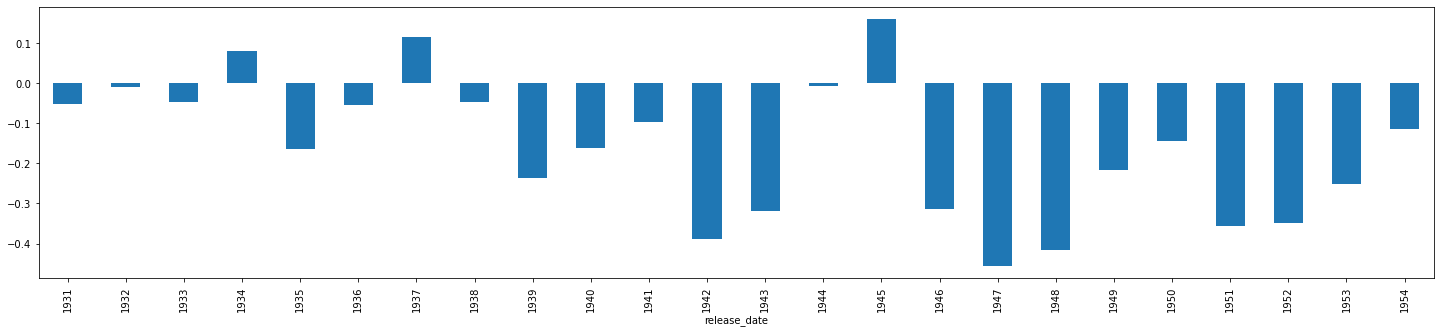

In [288]:
plot_sentiment_country_span(df_ww2_UK, 'compound', year=True)

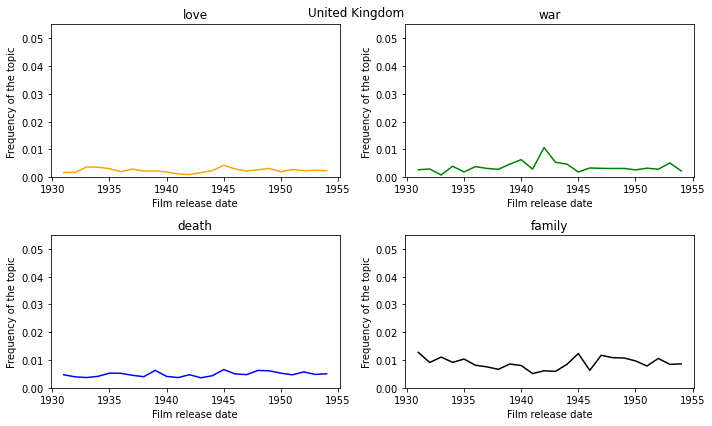

In [316]:
plot_topic_analysis_by_year(df_ww2_UK, begin+1, end, categories, "test4", "United Kingdom")

Seeing the compound value of all the movies at this period we can see that the war (1939-1945) overall sentiment is negative, execpt the last year (vicory for UK) where it is positive. 
Also the post war period is tainted with negativity  (1946 - 1951)

---

In [290]:
# This is for display the LDA of all the summaries of the dataframe.
display_uk, doc_term_matrix_uk, ldamodel_uk = LDA(df_ww2_UK, num_topics=3)
pyLDAvis.display(display_uk)

--- Here are all the topics found : ---
(0, '0.004*"find" + 0.004*"man" + 0.003*"go" + 0.003*"one" + 0.003*"love" + 0.003*"take" + 0.003*"woman" + 0.003*"police" + 0.003*"him" + 0.003*"get"')
---
(1, '0.004*"take" + 0.004*"find" + 0.003*"film" + 0.003*"mr" + 0.003*"return" + 0.003*"one" + 0.003*"love" + 0.003*"him" + 0.003*"man" + 0.003*"father"')
---
(2, '0.004*"find" + 0.004*"one" + 0.004*"go" + 0.003*"take" + 0.003*"back" + 0.003*"british" + 0.003*"ship" + 0.003*"train" + 0.003*"two" + 0.003*"make"')
---


We then run a sentiment analysis over all **soviet union** movie during this period **(1930 to 1955)**.

In [291]:
# get all the Russian movies
df_ww2_SovietUnion = get_country_movies(df_ww2, 'Soviet Union')

# calculate sentiment and add it nicely to the df
df_ww2_SovietUnion = sentiment_df(df_ww2_SovietUnion)

In [292]:
print("There is", len(df_ww2_SovietUnion), "movies made in Soviet Union bewteen", begin, "and", end)

There is 54 movies made in Soviet Union bewteen 1930 and 1955


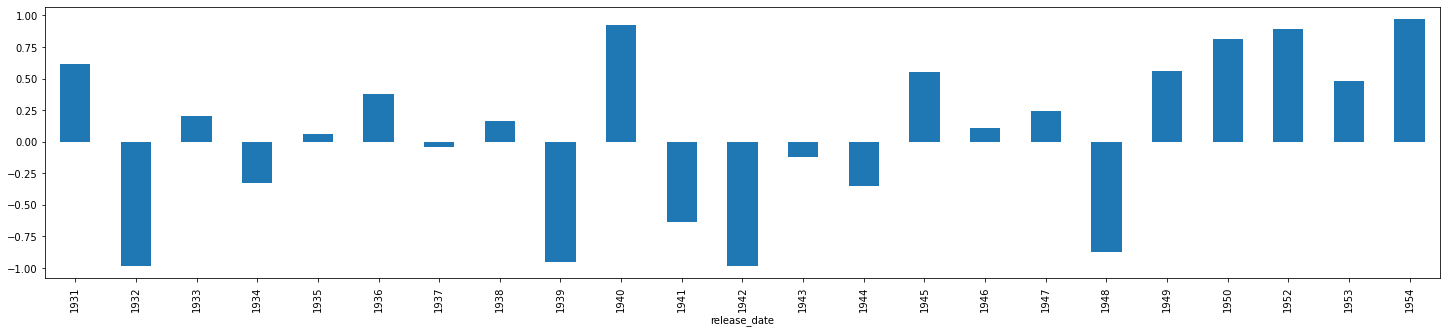

In [293]:
plot_sentiment_country_span(df_ww2_SovietUnion, 'compound', year=True)

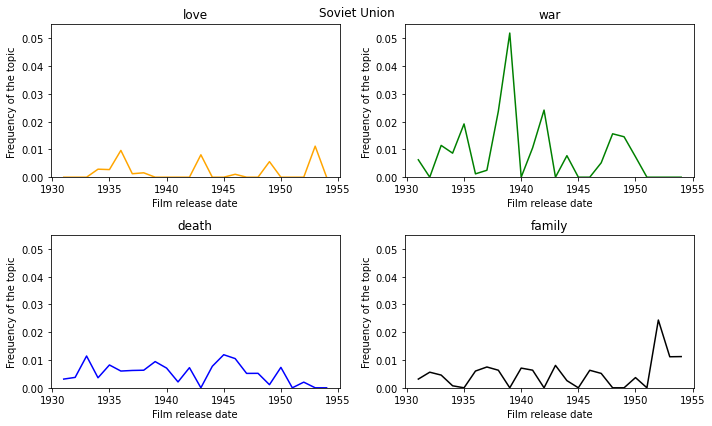

In [317]:
plot_topic_analysis_by_year(df_ww2_SovietUnion, begin+1, end, categories, "test5", "Soviet Union")

In [295]:
# This is for display the LDA of all the summaries of the dataframe.
display_rus, doc_term_matrix_rus, ldamodel_rus = LDA(df_ww2_SovietUnion, num_topics=3)
pyLDAvis.display(display_rus)

--- Here are all the topics found : ---
(0, '0.007*"yussuf" + 0.006*"father" + 0.006*"work" + 0.005*"alyosha" + 0.005*"flower" + 0.005*"go" + 0.005*"back" + 0.005*"mariya" + 0.004*"danilo" + 0.004*"however"')
---
(1, '0.010*"stalin" + 0.009*"german" + 0.009*"soviet" + 0.006*"red" + 0.006*"war" + 0.006*"army" + 0.006*"film" + 0.005*"soldier" + 0.004*"lenin" + 0.004*"russian"')
---
(2, '0.009*"ivan" + 0.004*"arrow" + 0.004*"moscow" + 0.004*"people" + 0.004*"tsar" + 0.004*"film" + 0.003*"vladimir" + 0.003*"prince" + 0.003*"musical" + 0.003*"novgorod"')
---


We then run a sentiment analysis over all **USA** movie during this period **(1930 to 1955)**.

In [296]:
# get all the USA movies
df_ww2_USA = get_country_movies(df_ww2, 'United States of America')

# calculate sentiment and add it nicely to the df
df_ww2_USA = sentiment_df(df_ww2_USA)

In [297]:
print("There is", len(df_ww2_USA), "movies made in USA bewteen", begin, "and", end)

There is 5592 movies made in USA bewteen 1930 and 1955


In [298]:
print(most_common_sum(df_ww2_USA, 40))

[(' ', 7503), ('find', 4121), ('man', 4006), ('tell', 3597), ('leave', 3436), ('try', 3053), ('take', 2761), ('go', 2667), ('love', 2583), ('new', 2559), ('return', 2543), ('kill', 2403), ('come', 2204), ('tom', 2064), ('|', 2008), ('father', 1949), ('time', 1943), ('work', 1887), ('home', 1878), ('friend', 1860), ('get', 1820), ('run', 1816), ('fall', 1811), ('meet', 1781), ('help', 1769), ('see', 1768), ('marry', 1742), ('away', 1687), ('decide', 1670), ('money', 1659), ('end', 1642), ('arrive', 1639), ('give', 1622), ('turn', 1618), ('woman', 1607), ('life', 1594), ('day', 1590), ('want', 1568), ('later', 1560), ('police', 1555)]


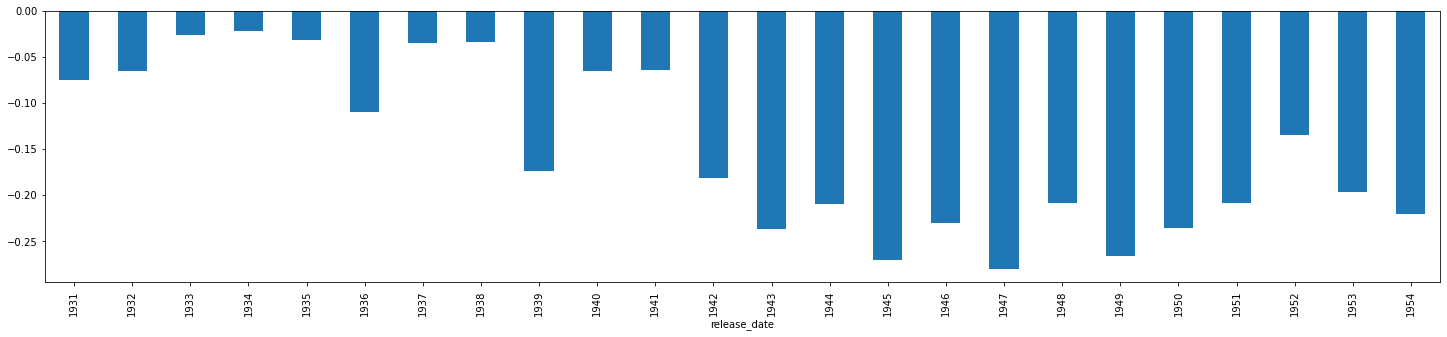

In [299]:
plot_sentiment_country_span(df_ww2_USA, 'compound', year=True)

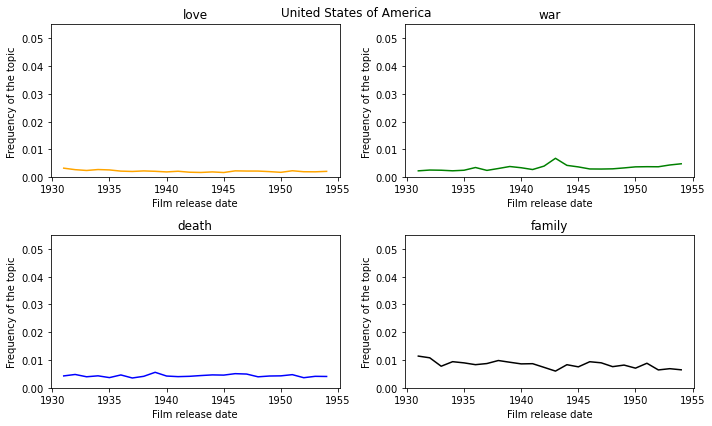

In [318]:
plot_topic_analysis_by_year(df_ww2_USA, begin+1, end, categories, "test6", "United States of America")

Seeing the compound value of all the movies at this period we can see that the war and prewar (1941-1951) overall sentiment is very negative. There is a clear mark between before the involvement of USA in the war and after.

---

In [301]:
# This is for display the LDA of all the summaries of the dataframe.
display_usa, doc_term_matrix_usa, ldamodel_usa = LDA(df_ww2_USA, num_topics=3)
pyLDAvis.display(display_usa)

--- Here are all the topics found : ---
(0, '0.005*"get" + 0.005*"find" + 0.004*"him" + 0.004*"tell" + 0.004*"go" + 0.004*"love" + 0.004*"new" + 0.004*"her" + 0.004*"take" + 0.004*"one"')
---
(1, '0.010*"tom" + 0.007*"jerry" + 0.006*"get" + 0.005*"back" + 0.004*"him" + 0.004*"go" + 0.004*"gang" + 0.004*"take" + 0.003*"run" + 0.003*"try"')
---
(2, '0.006*"bug" + 0.004*"war" + 0.004*"men" + 0.004*"one" + 0.004*"ship" + 0.003*"film" + 0.003*"captain" + 0.003*"take" + 0.003*"back" + 0.003*"german"')
---


From this, we can see that there is a cluster containing the Tom & Jerry movies, with more lightweight topics than war.
Another contains more things like hero of war, men captain ship, clearly talking about going to war as a hero.
The last one

We then run a sentiment analysis over all **Japan** movie during this period **(1930 to 1955)**.

In [302]:
# get all the Japan movies
df_ww2_japan = get_country_movies(df_ww2, 'Japan')

# calculate sentiment and add it nicely to the df
df_ww2_japan = sentiment_df(df_ww2_japan)

In [303]:
print("There is", len(df_ww2_japan), "movies made in Japan bewteen", begin, "and", end)

There is 74 movies made in Japan bewteen 1930 and 1955


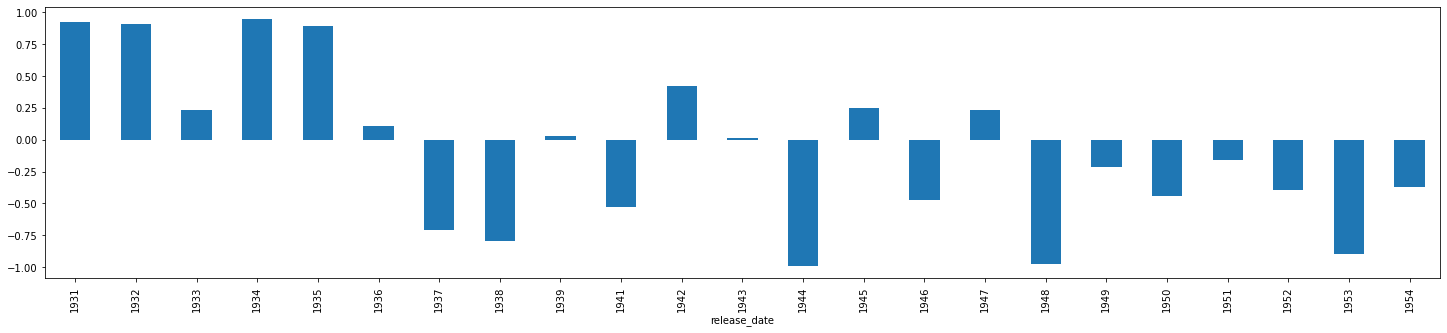

In [304]:
plot_sentiment_country_span(df_ww2_japan, 'compound', year=True)

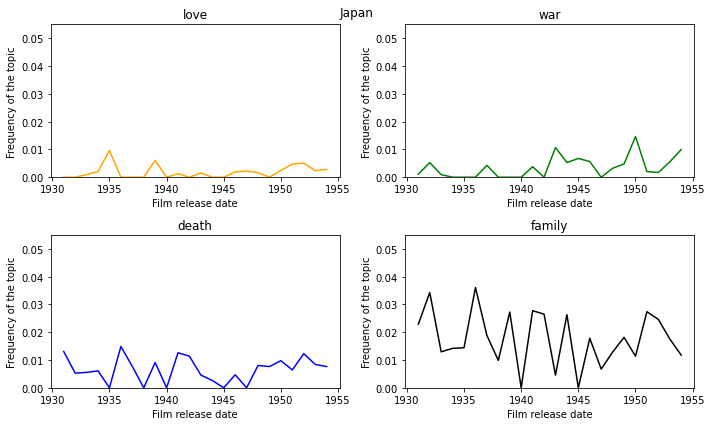

In [319]:
plot_topic_analysis_by_year(df_ww2_japan, begin+1, end, categories, "test7", "Japan")

Pre war (before 1939)  is pretty positive. The rest of the period is moslty negative.

In [306]:
# This is for display the LDA of all the summaries of the dataframe.
display_jap, doc_term_matrix_jap, ldamodel_jap = LDA(df_ww2_japan, num_topics=3)
pyLDAvis.display(display_jap)

--- Here are all the topics found : ---
(0, '0.006*"noriko" + 0.006*"miyoharu" + 0.005*"tokyo" + 0.005*"father" + 0.005*"go" + 0.004*"miyoei" + 0.004*"godzilla" + 0.004*"noge" + 0.004*"family" + 0.004*"take"')
---
(1, '0.008*"son" + 0.005*"go" + 0.005*"home" + 0.005*"return" + 0.005*"one" + 0.005*"money" + 0.005*"father" + 0.004*"find" + 0.004*"tell" + 0.004*"kihachi"')
---
(2, '0.007*"father" + 0.006*"samurai" + 0.005*"find" + 0.004*"husband" + 0.004*"home" + 0.004*"two" + 0.004*"taeko" + 0.004*"him" + 0.004*"wife" + 0.004*"morito"')
---


#### LDA !

In [307]:
lemma = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
names_set = {'lucas', 'pierre', 'baptiste', 'garance', 'marius', 'jean', 'roxane', 'jeanne', 'george', 'émile', 'louis', 'louise', 'robert', 
             'mario', 'françois', 'fanny', 'liliom', 'michel', 'frédérick', 'christina', 'christian', 'christine', 'andré', 'george', 
             'edmund', 'julie', 'marie', 'jo', 'anne', 'genevieve', 'max', 'claire'}


# remove stopwords and punctuation
def clean_text(text):
    no_stopwords = ' '.join([word for word in text.lower().split() if word not in stopwords_set])
    no_punctuation = ''.join(ch for ch in no_stopwords if ch not in punctuation_set)
    no_names = ' '.join([word for word in no_punctuation.split() if word not in names_set])
    return no_names

# lemmatize the text
def lemmatize(text):
    lemmatized = ' '.join([lemma.lemmatize(word) for word in text.split()])
    return lemmatized.split()

# compute the LDA for the given dataframe
def LDA(dataframe, num_topics=5):
    
    # remove stopwords and punctuation in the summaries
    dataframe['clean_summary'] = dataframe['summary'].apply(clean_text)
    
    # lemmatize the summaries
    dataframe['clean_summary'] = dataframe['clean_summary'].apply(lemmatize)
    
    # create dictionary (all unique words in all the summaries)
    dictionary = corpora.Dictionary(dataframe['clean_summary'])
    
    # create the document term matrix (frequencies and number of words : bag of words)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataframe['clean_summary']]

    # init the LDA model
    lda = gensim.models.ldamodel.LdaModel
    
    # compute the LDA
    ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)
    
    # print the topics found
    print("--- Here are all the topics found : ---")
    topics = ldamodel.print_topics()
    for i in range(len(topics)):
        print(topics[i])
        print("---")
        
    lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=True, mds='mmds')
    
    return lda_display, doc_term_matrix, ldamodel

In [308]:
df_ww2_germany.head()

,wiki_id,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres,directors,summary,sentiment,positive,neutral,negative,compound,clean_summary
791,21234681,/m/05c4_y9,Jud Süß,1940-01-01,NaN,98.0,[German Language],"[Nazi Germany, Germany]","[Propaganda film, Drama]",[[[Veit Harlan]]],The film begins with the coronation of Karl Al...,"{'neg': 0.039, 'neu': 0.833, 'pos': 0.128, 'co...",0.128,0.833,0.039,0.7783,"[film, begin, coronation, karl, alexander, duk..."
836,6847340,/m/0gsc8r,The Living Dead,1932-09-07,NaN,89.0,[German Language],"[Weimar Republic, Germany]","[Silent film, Horror, Indie, Science Fiction, ...",[[[Richard Oswald]]],"A crazed scientist, Morder , driven even crazi...","{'neg': 0.123, 'neu': 0.809, 'pos': 0.068, 'co...",0.068,0.809,0.123,-0.8402,"[crazed, scientist, morder, driven, even, craz..."
945,22811780,/m/0640172,Lachende Erben,1933-01-01,NaN,76.0,[],[Germany],"[Romance Film, Comedy]",[[[Max Ophüls]]],A young salesman may inherit a wine-estate on ...,"{'neg': 0.0, 'neu': 0.92, 'pos': 0.08, 'compou...",0.080,0.920,0.000,0.2057,"[young, salesman, may, inherit, wineestate, on..."
2284,33128846,/m/0crvz0t,The Axe of Wandsbek,1951-05-11,NaN,111.0,[German Language],"[German Democratic Republic, Germany]","[Drama, World cinema]",[[[Falk Harnack]]],"1934, Hamburg. Adolf Hitler is about to visit ...","{'neg': 0.188, 'neu': 0.759, 'pos': 0.053, 'co...",0.053,0.759,0.188,-0.9571,"[1934, hamburg, adolf, hitler, visit, city, ha..."
2334,33550875,/m/0hgrtj_,The Rothschilds,1940-01-01,NaN,NaN,[],[Germany],"[Biographical film, Drama]",[[[Erich Waschneck]]],"Because William I, Elector of Hesse did not jo...","{'neg': 0.101, 'neu': 0.802, 'pos': 0.098, 'co...",0.098,0.802,0.101,-0.3907,"[william, i, elector, hesse, join, confederati..."


In [309]:
df_ger = get_country_movies(df_movies, "Japan")

In [310]:
def count_by_period(df):
    prewar_begin, prewar_end = 1932, 1938
    df_prewar = create_history_span(df, prewar_begin, prewar_end)
    
    war_begin, war_end = 1939, 1945
    df_war = create_history_span(df, war_begin, war_end)
    
    postwar_begin, postwar_end = 1946, 1952
    df_postwar = create_history_span(df, postwar_begin, postwar_end)
    
    count_prewar = len(df_prewar)
    count_war = len(df_war)
    count_postwar = len(df_postwar)
    
    counts = [count_prewar, count_war, count_postwar]
    periods = ["1932-1938", "1939-1945", "1946-1952"]
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(periods, counts, label = "Number of movies")
    
    plt.xlabel("Period of time")
    plt.ylabel("Number of movie")
    plt.legend()
    
    return count_prewar, count_war, count_postwar

In [311]:
count_by_period(df_ger)

AttributeError: Can only use .dt accessor with datetimelike values